<a href="https://colab.research.google.com/github/shafi21001/PRNG/blob/main/prng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


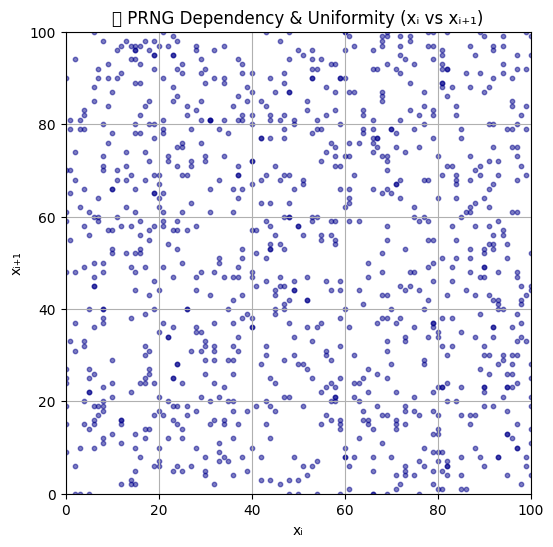

In [6]:
import os
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class CustomPRNG:
    def __init__(self, count=1000):
        entropy = os.urandom(32)
        hashed = hashlib.sha256(entropy).hexdigest()
        self.state = int(hashed, 16) & 0xFFFFFFFF
        self.counter = 0
        self.count = count

    def next(self):
        self.state = (self.state ^ (self.state << 13)) & 0xFFFFFFFF
        self.state = (self.state ^ (self.state >> 17)) & 0xFFFFFFFF
        self.state = (self.state ^ (self.state << 5)) & 0xFFFFFFFF
        digest = hashlib.sha256(str(self.state + self.counter).encode()).hexdigest()
        self.counter += 1
        return int(digest, 16) % 101

    def generate(self):
        return [self.next() for _ in range(self.count)]


prng = CustomPRNG(count=1000)
numbers = prng.generate()

# Scatter Plot: (x_i, x_{i+1}) to check uniformity and dependency
x_vals = numbers[:-1]
y_vals = numbers[1:]

plt.figure(figsize=(6, 6))
plt.scatter(x_vals, y_vals, alpha=0.5, s=10, color='darkblue')
plt.title("PRNG Dependency & Uniformity (xᵢ vs xᵢ₊₁)")
plt.xlabel("xᵢ")
plt.ylabel("xᵢ₊₁")
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()
